In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning

#### Deleting the 'Unnamed 0' column

#### Renaming Price and Property Size indicative of unit

In [2]:
d1 = pd.read_csv('housing.csv')
d1.drop('Unnamed: 0', axis = 1, inplace=True)
d1.rename(columns={'Property Value':'Price(in Crores)','Property Size':'Property Size(in sqft)','Specifications':'Apartments-BHK'},inplace=True)
d1.head(5)

,Price(in Crores),Project,Apartments-BHK,Property Size(in sqft)
0,70 L,No data,2 BHK Apartment,850
1,1.35 Cr,Godrej 24,3 BHK Apartment,1530
2,75 L,TCG The Crown Greens Phase 2,2 BHK Apartment,1365
3,1 Cr,Kolte Patil Green Olive,3 BHK Apartment,1500
4,45 L,No data,Residential Plot,10000


In [3]:
d1.shape

(600, 4)

### Converting lakhs to Crores to match the title and dropping the unit

In [4]:
# 1 lakh is 0.01 Cr
d2 = d1.copy()
 
d2['Price(in Crores)'] = d2['Price(in Crores)'].apply(lambda x: float(x.split()[0])*0.01 if 'L' in x.split()[1] else x.split()[0])
d2['Price(in Crores)'] = pd.to_numeric(d2['Price(in Crores)'])

### The data scraped for the first 30 pages is mostly that of Apartments.
### It would be best to delete other categories as they are merely countable and could heavily influence the price

# The data will hence be about apartments on listing

In [5]:
not_needed = ['Residential','Independent','Villa']
for i in not_needed:
    d2 = d2[~d2['Apartments-BHK'].str.contains(i)]

In [6]:
d2['Apartments-BHK'].value_counts()

2 BHK Apartment    340
3 BHK Apartment    163
1 BHK Apartment     75
4 BHK Apartment      7
5 BHK Apartment      3
Name: Apartments-BHK, dtype: int64

In [7]:
#dropping the extra strings in Apartment and converting the data type
d2['Apartments-BHK'] = d2['Apartments-BHK'].apply(lambda x: x.split()[0])
d2.head()

,Price(in Crores),Project,Apartments-BHK,Property Size(in sqft)
0,0.70,No data,2,850
1,1.35,Godrej 24,3,1530
2,0.75,TCG The Crown Greens Phase 2,2,1365
3,1.00,Kolte Patil Green Olive,3,1500
7,0.70,No data,3,1340


In [8]:
d2['Price(in Crores)'].describe()

count    588.000000
mean       0.647923
std        0.244578
min        0.240300
25%        0.500000
50%        0.610000
75%        0.749900
max        2.300000
Name: Price(in Crores), dtype: float64

### Mean is more than the mode , indicating a small amount of right skew

In [9]:
print("skew: {}".format(d2['Price(in Crores)'].skew()))

skew: 2.4188464218122525


## skew: 2.42

Text(0.5, 0.98, 'Price distribution')

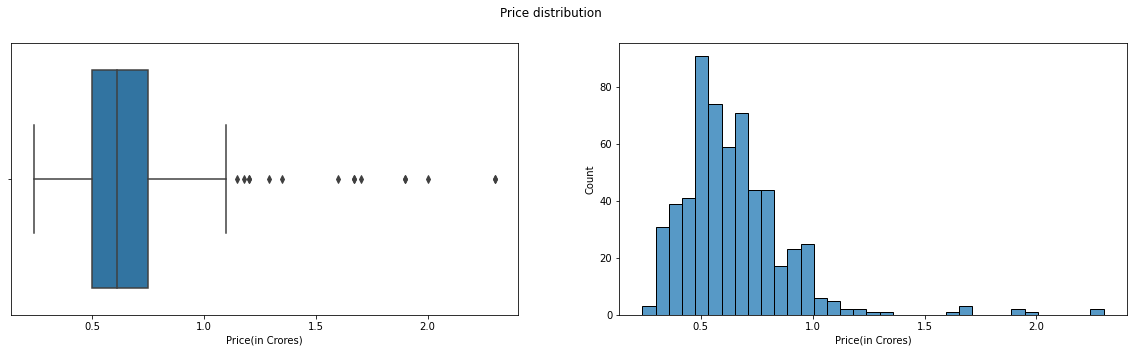

In [10]:
fig,ax = plt.subplots(1,2, sharex= True,figsize=(20,5))

sns.boxplot(ax=ax[0],x=d2['Price(in Crores)'])
sns.histplot(ax=ax[1],x=d2['Price(in Crores)'])
fig.suptitle('Price distribution')

### Removing outliers based on this observation

In [11]:
q1=d2['Price(in Crores)'].quantile(0.25)
q3=d2['Price(in Crores)'].quantile(0.75)
q1,q3

(0.5, 0.7499)

In [12]:
IQR = q3-q1

In [13]:
lower = q1-1.5*IQR
upper = q3+1.5*IQR
lower, upper

(0.12514999999999998, 1.1247500000000001)

In [14]:
d2 = d2[(d2['Price(in Crores)']>lower)&(d2['Price(in Crores)']<upper)]

Text(0.5, 0.98, 'Price distribution')

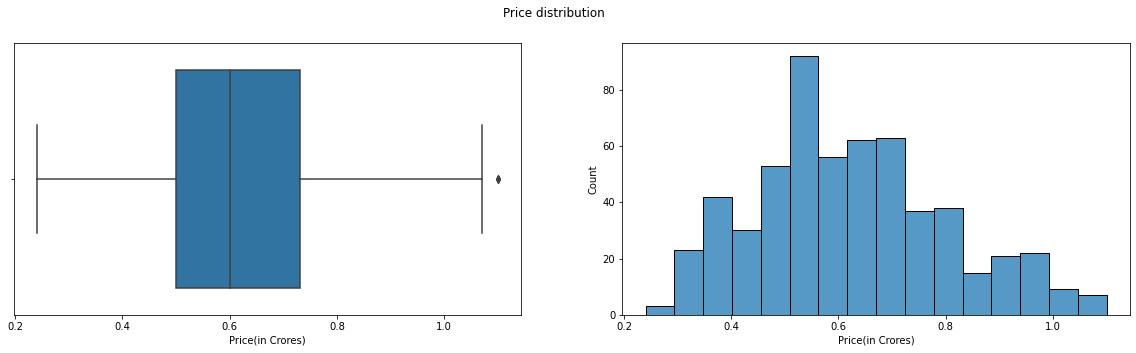

In [15]:
fig,ax = plt.subplots(1,2, sharex= True,figsize=(20,5))

sns.boxplot(ax=ax[0],x=d2['Price(in Crores)'])
sns.histplot(ax=ax[1],x=d2['Price(in Crores)'])
fig.suptitle('Price distribution')

### The first name of the developers can be used to check how the name can affect the price range of the apartments

In [16]:
d2['Project'] = d2['Project'].apply(lambda x: x.split()[0])

In [17]:
d2.head()

,Price(in Crores),Project,Apartments-BHK,Property Size(in sqft)
0,0.7000,No,2,850
2,0.7500,TCG,2,1365
3,1.0000,Kolte,3,1500
7,0.7000,No,3,1340
8,0.6906,Shapoorji,2,702


## Project and Apartments are being considered as categorical data and will be One-hot encoded

### Because each feature is multi categorical , only top 10 values of each feature will be considered

In [18]:
top_10_developers = [i for i in d2['Project'].value_counts(ascending = False).head(10).index]

Apartments = [i for i in d2['Apartments-BHK'].value_counts().index]

In [19]:
def one_hot_for_features(df,feature, top_10_dev):
    for dev in top_10_dev:
        df[feature+'_'+dev] = np.where(df[feature]==dev,1,0)

one_hot_for_features(d2,'Project',top_10_developers)
one_hot_for_features(d2,'Apartments-BHK',Apartments)

d2.drop(['Project','Apartments-BHK'],axis=1,inplace=True)

<AxesSubplot:>

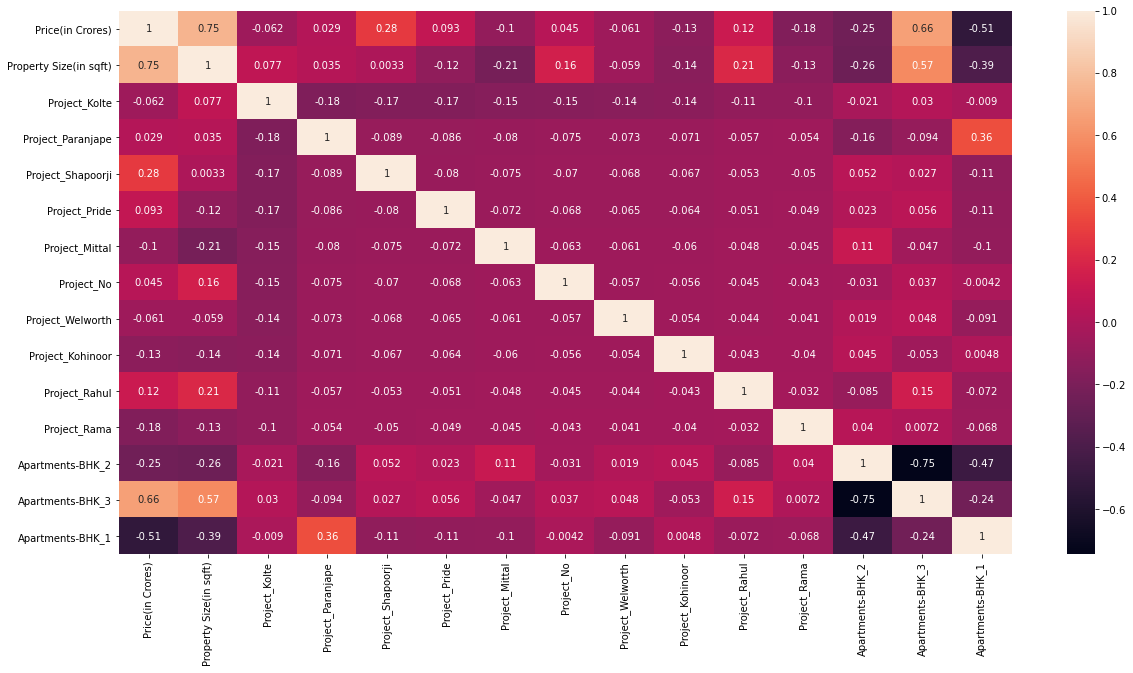

In [20]:
cor = d2.corr()
fig, ax = plt.subplots(figsize= (20, 10))
sns.heatmap(cor, annot= True)

>Price is  affected by the property size

>negative correlation between price and the 1 bhk apartments - ofcourse not many of 1 bhks will be costly

>property size affects 3 bhk apartments positively

#### Splitting data

In [21]:
d2.columns

Index(['Price(in Crores)', 'Property Size(in sqft)', 'Project_Kolte',
       'Project_Paranjape', 'Project_Shapoorji', 'Project_Pride',
       'Project_Mittal', 'Project_No', 'Project_Welworth', 'Project_Kohinoor',
       'Project_Rahul', 'Project_Rama', 'Apartments-BHK_2', 'Apartments-BHK_3',
       'Apartments-BHK_1'],
      dtype='object')

In [22]:
X = d2[['Property Size(in sqft)', 'Project_Kolte',
       'Project_Paranjape', 'Project_Shapoorji', 'Project_Pride',
       'Project_Mittal', 'Project_No', 'Project_Welworth', 'Project_Kohinoor',
       'Project_Rahul', 'Project_Rama', 'Apartments-BHK_2', 'Apartments-BHK_3',
       'Apartments-BHK_1']]
y = d2['Price(in Crores)']

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state = 40)

## Training Models

### Linear Regression

In [25]:
#training the algorithm
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [26]:
#looking for the best intercept and slope
print(regressor.intercept_)

print(regressor.coef_)

0.3779563551290276
[ 0.00024699 -0.02637686  0.08995909  0.15067656  0.06362757 -0.01800414
 -0.02439664 -0.05998095 -0.03873184 -0.0404388  -0.12346289  0.00329128
  0.15082649 -0.15411777]


In [27]:
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [28]:
df = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})


<AxesSubplot:xlabel='Price(in Crores)'>

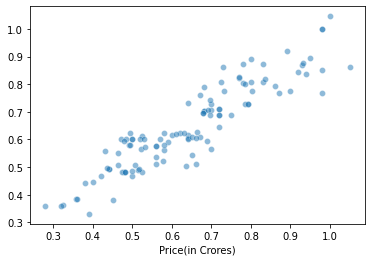

In [29]:
sns.scatterplot(x=y_test,y=y_pred,alpha=0.5)

In [30]:
print('Mean Squared Error:', (metrics.mean_squared_error(y_test,y_pred)))
print('Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print("R2 score on Train data:",metrics.r2_score(y_train,y_pred_train))
print("R2 score on test data:",metrics.r2_score(y_test,y_pred))


Mean Squared Error: 0.004824064120640313
Root Mean Squared Error : 0.06945548301351243
R2 score on Train data: 0.813052967265944
R2 score on test data: 0.8352637825495671


##### R2 score better on testing rather than training indicates high variance, increasing the size of the dataset could show better results

## Decision Tree Regressor

In [31]:
dt_model = DecisionTreeRegressor(max_depth=4,min_samples_leaf=0.1,random_state=1)
dt_model.fit(X_train,y_train)
y_pred_train_dt = regressor.predict(X_train)
y_pred_dt = dt_model.predict(X_test)

In [32]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_dt)))
print("R2 score on Train data:",metrics.r2_score(y_train,y_pred_train_dt))
print("R2 score on test data:",metrics.r2_score(y_test,y_pred_dt))

Root Mean Squared Error: 0.10626279206696429
R2 score on Train data: 0.813052967265944
R2 score on test data: 0.6143987227255935


<AxesSubplot:xlabel='Price(in Crores)'>

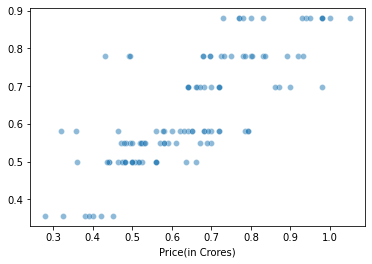

In [33]:
sns.scatterplot(x=y_test,y=y_pred_dt,alpha=0.5)

In [35]:
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train) 
pred_train_lasso= lasso_reg.predict(X_train)
pred_test_lasso= lasso_reg.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,pred_test_lasso)))
print("R2 score on Train data:",metrics.r2_score(y_train,pred_train_lasso))
print("R2 score on test data:",metrics.r2_score(y_test,pred_test_lasso))

Root Mean Squared Error: 0.07145826566537432
R2 score on Train data: 0.80587107964403
R2 score on test data: 0.8256263088164006


<AxesSubplot:xlabel='Price(in Crores)'>

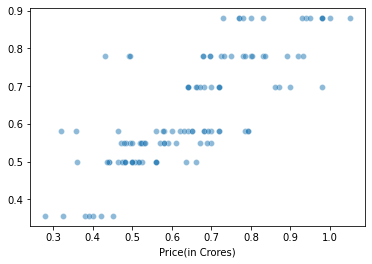

In [36]:
sns.scatterplot(x=y_test,y=y_pred_dt,alpha=0.5)

## Random Forest Regressor

In [37]:
random_regressor = RandomForestRegressor(n_estimators = 100, random_state = 1)
random_regressor.fit(X_train,y_train)
y_random_pred_test = random_regressor.predict(X_test)
y_random_pred_train = random_regressor.predict(X_train)

In [38]:
print('Mean Squared Error:', (metrics.mean_squared_error(y_test,y_random_pred_test)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_random_pred_test)))
print("R2 score on Train data:",metrics.r2_score(y_train,y_random_pred_train))
print("R2 score on test data:",metrics.r2_score(y_test,y_random_pred_test))

Mean Squared Error: 0.004390868924513199
Root Mean Squared Error: 0.06626363199005318
R2 score on Train data: 0.9711561446060069
R2 score on test data: 0.8500568981141685


<AxesSubplot:xlabel='Price(in Crores)'>

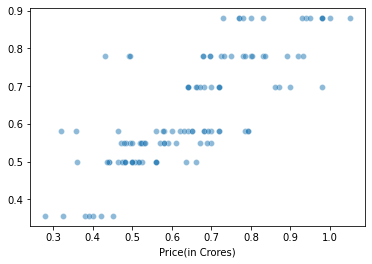

In [39]:
sns.scatterplot(x=y_test,y=y_pred_dt,alpha=0.5)

## Comparison

|Models                 | |RMSE    | |R2 train| |R2 test|
|-----------------------| |--------| |--------| |------|
|Linear Regression      | |0.069455| |0.813   |  |0.835 |
|Decision Tree Regressor| |0.10626 | |0.813   |   |0.614| 
|Lasso                  | |0.071   | |0.805   |  |0.825 |
|Random Forest          | |0.066   | |0.97    |   |0.85 | 

## Conclusion      

> Random Forest Regressor > Linear Regression > Decision Tree Regressor > Lasso

> Lasso-the alpha value = 0.01 gives good results, but such low alpha values just indicate that this works almost like a simple linear regression model

> Linear Regression = better R2 values for test data indicate high variation

> The models here predict the price for Apartment listings from Makaan.com

 Further, 
 > For better results:
     > The size of the dataset should be increased.
     
     > There is imbalance in the values of the categorical terms like the number of apartments and developers
     
     > So the model will probably be able to better predict any categorical variable that is more in number
     
     > SMOTE could be a technique that can be used to deal with imbalance.
     
     > Parameters for Lasso and Random Forest can further be tuned to improve the accuracy a little more 
     
     > Realistically, Many other factors affect the price of real estate, facotring them all in , would be great help to make    better predictions